# Lab 08: Airline Tweets Sentiment Analysis

---
author: Brady Brooks
date: November 8, 2024
embed-resources: true
---

## Introduction

In this report, I build a model to predict the sentiment of a comment posted on the platform formally known as Twitter. The goal is to accurately classify tweets as positive, negative, and neutral using Logistic Regression. For the negative comments, we will notify customer service to respond, and for the positive comments, we will automatically acknowledge them.

## Methods

In [1]:
# imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, fbeta_score, make_scorer
import warnings

### Data

In [2]:
# load data
tweets = pd.read_csv("https://cs307.org/lab-08/data/tweets.csv")
tweets_train, tweets_test = train_test_split(tweets, test_size=0.25, random_state=42)
tweets_train

,sentiment,airline,text
2233,positive,Delta,@JetBlue Then en route to the airport the rebo...
10733,negative,United,@united now you've lost my bags too. At least...
400,neutral,US Airways,"@USAirways Hi, can you attach my AA FF# 94LXA6..."
7615,positive,United,"@United, will you fill it? Yes they will. Than..."
4099,negative,American,@AmericanAir thanks! I hope we get movies. Tv'...
...,...,...,...
5734,negative,United,@united Can i get a refund? I would like to bo...
5191,neutral,Virgin America,@VirginAmerica what is your policy on flying a...
5390,negative,United,@united I'm not sure how you can help. Your fl...
860,neutral,Virgin America,@VirginAmerica LAX to EWR - Middle seat on a r...


Data from this report was accessed from Kaggle and Twitter. Each observation contains a tweet, who the tweet was sent to, and whether the tweet is positive, negative, or neutral.

## Data Dictionary

##### Response

sentiment
-   [object] the sentiment of the tweet (Negative, Neutral, or Positive)


##### Features

text
-   [object] the full text of the tweet

airline
-   [object] the airline the tweet was sent to

In [3]:
# summary statistics
temp = tweets_train.copy()
dfair = tweets_train.groupby("airline").agg("count").reset_index()
display(dfair[["airline", "sentiment"]])

,airline,sentiment
0,American,1551
1,Delta,1239
2,Southwest,1347
3,US Airways,1664
4,United,2166
5,Virgin America,268


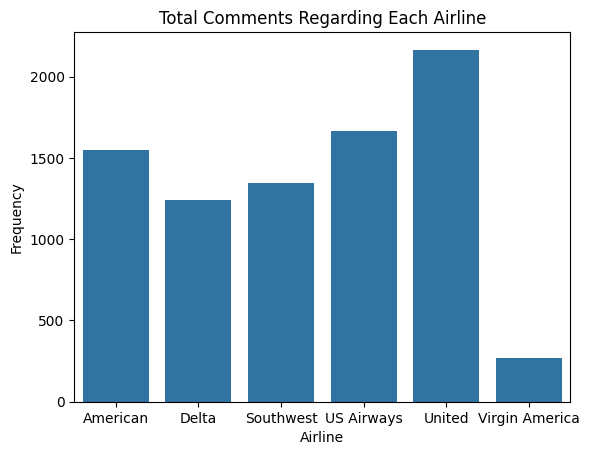

In [4]:
# visualizations
sns.barplot(data=dfair, x="airline", y="sentiment")
plt.title("Total Comments Regarding Each Airline")
plt.xlabel("Airline")
plt.ylabel("Frequency")
plt.show()

The chart above represents the quantity of each airline represented in this model. We can see that some airlines are represented a lot more than others. 

### Models

In [5]:
# process data for ML
# create X and y for train data
X_train = tweets_train["text"]
y_train = tweets_train["sentiment"]

# create X and y for test data
X_test = tweets_test["text"]
y_test = tweets_test["sentiment"]
top_100_counter = CountVectorizer(max_features=100)
X_top_100 = top_100_counter.fit_transform(X_train)
X_top_100_dense = X_top_100.todense()
cancelled_idx = np.where(top_100_counter.get_feature_names_out() == "cancelled")
cancelled_count = np.sum(X_top_100.todense()[:, cancelled_idx])
print('The Word "plane" Appears:', cancelled_count)
please_idx = np.where(top_100_counter.get_feature_names_out() == "please")
please_count = np.sum(X_top_100.todense()[:, please_idx])
print('The Word "plane" Appears:', please_count)
thanks_idx = np.where(top_100_counter.get_feature_names_out() == "thanks")
thanks_count = np.sum(X_top_100.todense()[:, thanks_idx])
print('The Word "plane" Appears:', thanks_count)

The Word "plane" Appears: 595
The Word "plane" Appears: 325
The Word "plane" Appears: 587


To develop a model, I tuned two different types of Logistic Regression models. One set with solvers that utilize l2 and none penalty and another set of solvers that utilize l1 and l2 penalty. For each set, I tuned the models using several available tuning parameters.

Furthermore, I removed the airline feature and vectorized the text feature. To do so, I used a count vectorizer to count how many instances of a word were in the text. Meaning there were many columns containing the count of the column's respective word in that text.

Tuning was performed via cross-validation using a grid-search of the specified parameters.

In [6]:
# train models
pipeline = Pipeline(steps=[
    ("Vectorizer", CountVectorizer()),
    ("Classifier", LogisticRegression())
])

In [12]:
param_grid = [
    {"Classifier": [LogisticRegression()],
    "Classifier__solver": ["lbfgs", "newton_cg", "newton_cholesky", "sag"],
    "Classifier__fit_intercept":  [False, True],
    "Classifier__C": [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
    "Classifier__penalty": [None, "l2"],
    "Vectorizer__max_features": [None],},
    {"Classifier": [LogisticRegression()],
    "Classifier__solver": ["liblinear", "saga"],
    "Classifier__fit_intercept":  [False, True],
    "Classifier__C": [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
    "Classifier__penalty": ["l1", "l2"],
    "Vectorizer__max_features": [None],}
]

In [ ]:
warnings.filterwarnings("ignore")
mod = GridSearchCV(pipeline, param_grid = param_grid, n_jobs=-1, cv=5, verbose=3, scoring="accuracy")
_ = mod.fit(X_train, y_train)

## Results

In [14]:
# report model metrics
mod.best_params_

{'Classifier': LogisticRegression(),
 'Classifier__C': 0.9,
 'Classifier__fit_intercept': True,
 'Classifier__penalty': 'l2',
 'Classifier__solver': 'liblinear',
 'Vectorizer__max_features': None}

Of the models considered, the chosen model was a Logistic Regression with a liblinear solver, penatly of l2, C of 0.9, and an intercept.

In [15]:
mod.best_score_

np.float64(0.786520947176685)

The chosen model achieves a cross-validation accuracy of 0.786520947176685.

## Discussion

The model that I have created, which is the Logistic Regression using the liblinear solver and the l2 penalty, was able to predict roughly 4 out of 5 tweets correctly. Another classifier should be tested to see if it cna increase accuracy. We care mainly about the accuracy of the model when it comes to negative comments. This way our customer service team can respond to all of the negative comments. If only 4 out of 5 negative tweets are being classified as negative, that means a lot of people are not receiving responses. If a positive tweet is mistakenly classified as negative, it is not a big deal because customer service with see it and just acknowledge it manually. Where as if a negative tweet is mistakenly classified as positive or neutral, this could be bad because then the negative tweet will not be addressed leading to even more furious customers. 

### Conclusion

At this moment, I do not believe this model is ready to be put into practice. The model could be improved by testing other classifiers and other vectorizers. The model poses to big of a risk as its accuracy for negatice tweets needs to be improved. 

In [16]:
from joblib import dump
dump(mod, "airline-sentiment.joblib")

['airline-sentiment.joblib']